In [0]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

In [0]:
class PermutedMNISTDataLoader(torchvision.datasets.MNIST):
    
    def __init__(self, source='./mnist_data', train = True, shuffle_seed = None):
        super(PermutedMNISTDataLoader, self).__init__(source, train, download=True)
        
        self.train = train
        if self.train:
            self.permuted_train_data = torch.stack(
                [img.type(dtype=torch.float32).view(-1)[shuffle_seed] / 255.0
                    for img in self.train_data])
        else:
            self.permuted_test_data = torch.stack(
                [img.type(dtype=torch.float32).view(-1)[shuffle_seed] / 255.0
                    for img in self.test_data])
            
    def __getitem__(self, index):
        
        if self.train:
            input, label = self.permuted_train_data[index], self.train_labels[index]
        else:
            input, label = self.permuted_test_data[index], self.test_labels[index]
        
        return input, label

    def sample(self, size):
        return [img for img in self.permuted_train_data[random.sample(range(len(self), size))]]
    
    '''
    def __len__(self):
        if self.train:
            return self.train_data.size()
        else:
            return self.test_data.size()
    '''

In [0]:
batch_size = 64
num_tasks = 10

def permute_mnist():
    train_loader = {}
    test_loader = {}
    
    for i in range(num_tasks):
        shuffle_seed = np.arange(28*28)
        np.random.shuffle(shuffle_seed)
        train_loader[i] = torch.utils.data.DataLoader(
            PermutedMNISTDataLoader(train=True, shuffle_seed=shuffle_seed),
                batch_size=batch_size)
        
        test_loader[i] = torch.utils.data.DataLoader(
            PermutedMNISTDataLoader(train=False, shuffle_seed=shuffle_seed),
                batch_size=batch_size)
    
    return train_loader, test_loader

train_loader, test_loader = permute_mnist()

0it [00:00, ?it/s]

9920512it [00:02, 3609153.60it/s]                             


Extracting ./mnist_data/PermutedMNISTDataLoader/raw/train-images-idx3-ubyte.gz to ./mnist_data/PermutedMNISTDataLoader/raw


0it [00:00, ?it/s]

32768it [00:00, 58503.21it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist_data/PermutedMNISTDataLoader/raw/train-labels-idx1-ubyte.gz to ./mnist_data/PermutedMNISTDataLoader/raw


1654784it [00:01, 973737.59it/s]                             
0it [00:00, ?it/s]

Extracting ./mnist_data/PermutedMNISTDataLoader/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/PermutedMNISTDataLoader/raw


8192it [00:00, 21788.05it/s]            
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Extracting ./mnist_data/PermutedMNISTDataLoader/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/PermutedMNISTDataLoader/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


### Define Neural Net

In [0]:
class NeuralNet(nn.Module):
    def __init__(self):
        # Always start with inheriting torch.nn.Module
        # Ancestor class of all Neural Net module
        super(NeuralNet, self).__init__()
        # Linear: linear transformation
        fc1 = nn.Linear(28*28, 400)
        fc2 = nn.Linear(400, 400)
        fc3 = nn.Linear(400, 10)
  
        
        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        if torch.cuda.is_available():
            self.fc_module = self.fc_module.cuda()

    def forward(self, x):
        return self.fc_module(x)

### Get Fisher Matrix

In [0]:
def fisher(net, data_loader, task):
    fisher_mat = []       
    for i in range(task):
        for n, data in enumerate(data_loader[i]):
            if(n == task-i-1):
                data_ = data[0]
                break

        if torch.cuda.is_available():
            data_ = data_.cuda()

        params = {n : p for n, p in net.named_parameters() if p.requires_grad}
        fisher_mat_per_task = {}
        for n, p in deepcopy(params).items():
            p.data.zero_()
            fisher_mat_per_task[n] = p.data

        net.eval()
        for data in data_:
            net.zero_grad()
            output = net(data).view(1, -1)
            pred = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), pred)
            loss.backward()

            for n, p in net.named_parameters():
                fisher_mat_per_task[n].data += p.grad.data ** 2 / len(data_)

        fisher_mat.append({n : p for n, p in fisher_mat_per_task.items()})
    return fisher_mat

############################################################################                
    '''
    params = {n : p for n, p in net.named_parameters() if p.requires_grad}
    fisher_mat = {}
    for n, p in deepcopy(params).items():
        p.data.zero_()
        fisher_mat[n] = p.data

    net.eval()
    for data in input:
        net.zero_grad()
        output = net(data).view(1, -1)
        pred = output.max(1)[1].view(-1)
        loss = F.nll_loss(F.log_softmax(output, dim=1), pred)
        loss.backward()

        for n, p in net.named_parameters():
            fisher_mat[n].data += p.grad.data ** 2 / len(input)

    fisher_mat = {n : p for n, p in fisher_mat.items()}
    #print("Time: %.3f" %(time.time() - start_time))
    return fisher_mat
    '''

### Learning Function

In [0]:
def Learning_Function(net, optimizer, num_tasks, reg_coef, learn_mode = 0):
    if learn_mode > 2 or learn_mode < 0:
        print("Learn mode Error\nplain: 0\tpenalty with L2 distance: 1\tpenalty with ewc: 2")
        return False

    criterion = nn.CrossEntropyLoss()
    num_epochs = 20
    sample_size = 100
    acc = {}
    params_per_tasks = []

    print("Task\tEpoch")
    for task in range(num_tasks):
        running_loss = 0.0
        
        # Get Fisher Matrix
        if len(params_per_tasks) != 0 and learn_mode == 2:
            fisher_mat = fisher(net, train_loader, task)
            
        # Train for each task
        for epoch in range(num_epochs):
            for i, data in enumerate(train_loader[task]):
                inputs, labels = data

                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # gradient initiallize
                optimizer.zero_grad()

                # Compute forward-propagation
                outputs = net(inputs)

                # Compute Loss
                loss = criterion(outputs, labels)

                # Compute Loss & L2 distance
                if learn_mode != 0:
                    reg = 0
                    ind = 0
                    for params_past in params_per_tasks:
                        for n, p in net.named_parameters():
                            if torch.cuda.is_available():
                                params_past[n] = params_past[n].cuda()
                                
                            penalty = (params_past[n] - p)**2
                            # EWC: multiply fisher matrix
                            if learn_mode == 2:
                                penalty = fisher_mat[ind][n] * penalty

                            reg += torch.sum(penalty)
                        ind += 1
                    loss = loss + (reg_coef / 2) * reg

                #Do Back-propagation
                loss.backward()
                #Weight update
                optimizer.step()

                #cumulate loss
                running_loss += loss.data.item()

            if epoch % 5 == 4:
                print('[%d\t%d] AVG. loss: %.3f' % (task+1, epoch + 1, running_loss/(i*5)))
                running_loss = 0.0

        # Save parameters to use at next iteration: used to cal. penalty term      
        if learn_mode != 0:
            tp = {n : p for n, p in net.named_parameters() if p.requires_grad}
            params = {}
            for n, p in deepcopy(tp).items():
                params[n] = p.data
            params_per_tasks.append(params)

            
        # Test for each task after learning a task.
        each_task_acc = []
        for j in range(task+1):
            total = 0
            correct = 0
            for i, data in enumerate(test_loader[j]):
                inputs, labels = data
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # forward propagation
                outputs = net(inputs)

                # torch.max: returns maximum value of a tensor
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                
                # Estimate accuracy of model
                correct += (predicted == labels).sum()
                                
            each_task_acc.append(100 * correct.cpu().numpy() / total)
            
        print(each_task_acc)
        each_task_acc = np.asarray(each_task_acc)
        print(each_task_acc)
        print('Average accuracy after training task %d: %d %%' % (task+1, np.mean(each_task_acc)))
        acc[task] = np.mean(each_task_acc)
            # For each input data, print the accuracy of the model
            #print('Accuracy of the network on the test images %d for task %d after training task %d: %d %%' 
            #                % (i, j, task+1, 100 * correct / total))
            
    return acc

### Plain SGD

In [0]:
def Plain_SGD_Learning(learning_rate, num_task):
    net = NeuralNet()
    if torch.cuda.is_available():
        print("Use GPU")
        net.cuda()
        
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)    
    return Learning_Function(net, optimizer, num_task, reg_coef=1, learn_mode=0)

### Continual Learning with L2 distance

In [0]:
def L2_Learning(learning_rate, num_task):
    learning_acc = {}
    reg_coef_list = [300,1000,3000,10000]
    for reg_coef in reg_coef_list:
        net = NeuralNet()
        if torch.cuda.is_available():
            print("Use GPU")
            net.cuda()
            
        optimizer = optim.SGD(net.parameters(), lr=learning_rate)    
        print("Penalty term coefficient: ", reg_coef)
        learning_acc[reg_coef] = Continual_Learning(net, optimizer, num_task, reg_coef, learn_mode=2)

    return learning_acc

### Continual Learning with Elastic Weight Consolidation

In [0]:
def EWC_Learning(learning_rate, num_task):
    learning_acc = {}
    reg_coef_list = [3, 10, 30, 100, 300, 1000, 3000, 10000]
    for reg_coef in reg_coef_list:
        net = NeuralNet()
        if torch.cuda.is_available():
            print("Use GPU")
            net.cuda()
            
        optimizer = optim.SGD(net.parameters(), lr=learning_rate)    
        print("Penalty term coefficient: ", reg_coef)
        learning_acc[reg_coef] = Continual_Learning(net, optimizer, num_task, reg_coef, learn_mode=2)

    return learning_acc

In [0]:
learning_rate = 1e-3
num_task = 10

SGD_acc = Plain_SGD_Learning(learning_rate, num_task)

Use GPU
Task	Epoch


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


[1	5] AVG. loss: 2.111
[1	10] AVG. loss: 1.069
[1	15] AVG. loss: 0.569
[1	20] AVG. loss: 0.443
[89.14]
[89.14]
Average accuracy after training task 1: 89 %


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[2	5] AVG. loss: 0.786
[2	10] AVG. loss: 0.436
[2	15] AVG. loss: 0.373
[2	20] AVG. loss: 0.340
[86.53, 90.9]
[86.53 90.9 ]
Average accuracy after training task 2: 88 %
[3	5] AVG. loss: 0.643
[3	10] AVG. loss: 0.388
[3	15] AVG. loss: 0.342
[3	20] AVG. loss: 0.314
[79.7, 87.65, 91.49]
[79.7  87.65 91.49]
Average accuracy after training task 3: 86 %
[4	5] AVG. loss: 0.605
[4	10] AVG. loss: 0.369
[4	15] AVG. loss: 0.326
[4	20] AVG. loss: 0.300
[77.31, 82.56, 89.13, 91.94]
[77.31 82.56 89.13 91.94]
Average accuracy after training task 4: 85 %
[5	5] AVG. loss: 0.596
[5	10] AVG. loss: 0.349
[5	15] AVG. loss: 0.306
[5	20] AVG. loss: 0.280
[75.08, 76.49, 82.57, 86.03, 92.41]
[75.08 76.49 82.57 86.03 92.41]
Average accuracy after training task 5: 82 %
[6	5] AVG. loss: 0.574
[6	10] AVG. loss: 0.339
[6	15] AVG. loss: 0.296
[6	20] AVG. loss: 0.269
[72.97, 73.89, 77.2, 78.82, 89.23, 92.71]
[72.97 73.89 77.2  78.82 89.23 92.71]
Average accuracy after training task 6: 80 %
[7	5] AVG. loss: 0.554
[7	10

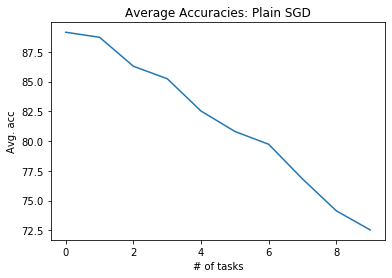

In [0]:
x, y = list(SGD_acc.keys()), list(SGD_acc.values())
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies: Plain SGD")
plt.plot(x, y)
plt.show()

In [0]:
EWC_acc = EWC_Learning(learning_rate, num_task)

Use GPU
Penalty term coefficient:  3
Task	Epoch


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


[1	5] AVG. loss: 2.115
[1	10] AVG. loss: 1.063
[1	15] AVG. loss: 0.567
[1	20] AVG. loss: 0.443
[89.25]
[89.25]
Average accuracy after training task 1: 89 %


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[2	5] AVG. loss: 0.790
[2	10] AVG. loss: 0.443
[2	15] AVG. loss: 0.383
[2	20] AVG. loss: 0.351
[86.61, 90.79]
[86.61 90.79]
Average accuracy after training task 2: 88 %
[3	5] AVG. loss: 0.676
[3	10] AVG. loss: 0.412
[3	15] AVG. loss: 0.367
[3	20] AVG. loss: 0.341
[79.93, 87.84, 91.48]
[79.93 87.84 91.48]
Average accuracy after training task 3: 86 %
[4	5] AVG. loss: 0.646
[4	10] AVG. loss: 0.407
[4	15] AVG. loss: 0.365
[4	20] AVG. loss: 0.341
[79.0, 82.69, 88.8, 91.66]
[79.   82.69 88.8  91.66]
Average accuracy after training task 4: 85 %
[5	5] AVG. loss: 0.670
[5	10] AVG. loss: 0.415
[5	15] AVG. loss: 0.374
[5	20] AVG. loss: 0.350
[81.17, 79.6, 82.62, 86.36, 91.78]
[81.17 79.6  82.62 86.36 91.78]
Average accuracy after training task 5: 84 %
[6	5] AVG. loss: 0.677
[6	10] AVG. loss: 0.433
[6	15] AVG. loss: 0.391
[6	20] AVG. loss: 0.366
[77.15, 79.54, 80.79, 82.28, 87.74, 92.0]
[77.15 79.54 80.79 82.28 87.74 92.  ]
Average accuracy after training task 6: 83 %
[7	5] AVG. loss: 0.663
[7	10]